In [3]:
from astroquery.sdss import SDSS
import math
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from specutils.fitting import fit_generic_continuum
from specutils import Spectrum
from labellines import labelLines
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import scipy

plt.rcParams['agg.path.chunksize'] = 120

### Import a Spectra from astroquery.sdss

In [4]:
plate = 4531
mjd = 55563
fiber = 115

#Get spectra from astroquery
sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)

spec_hdu = sp[0]
spec_data = spec_hdu[1].data #data with the fits

z = spec_hdu[2].data["z"]

#print out the headers
header = spec_hdu[0].header

#set parameters
loglam = spec_data['loglam']
uncert = 1/np.sqrt(spec_data['ivar'])
flux = spec_data['flux']
wavelength = 10**loglam
print(spec_hdu[1].columns)

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)


C:\Users\nihad\AppData\Local\Temp\ipykernel_32588\1311762401.py:18: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


### Plot the spectra 

C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:181: UserWarning: Tried to label line Line2D(_child6), but could not find a label for it.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=6564.610000000001, xmax=6564.610000000001, xval=6564.61). Clipping it into the allowed range.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=5008.240000000001, xmax=5008.240000000001, xval=5008.24). Clipping it into the allowed range.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 4 in `xvals` is outside the range of its associated line (xmin=4102.890000000001, xmax=4102.890000000001, xval=4102.89). Clipping it into the allowed range.
  warnings.warn(


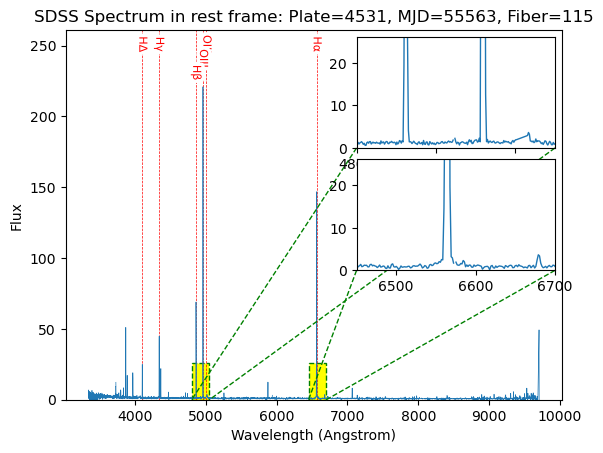

In [7]:
fig, ax = plt.subplots()

#common spectral lines in SDSS
xvals = [6564.61, 5008.240, 4960.295, 4862.68, 4102.89, 4341.68]
label = ['Hα', 'OIII', 'OIII', 'Hβ', 'HΔ', 'Hγ']

for i in range(len(xvals)):
     plt.axvline(xvals[i], color="red", linewidth=0.5, linestyle="--", label= label[i])

#plot the spectrum
ax.plot(wavelength/(1+z), flux, linewidth=0.5)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
y_top = max(flux) + 40
plt.ylim(0,y_top)
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#vertical lines
offset = [y_top/2-10, y_top/2-10, y_top/2-20, y_top/2-30, y_top/2-10, y_top/2-10]
lines = plt.gca().get_lines()
labelLines(lines, align=True, yoffsets=offset, xvals = xvals, fontsize = 8)

#inset plot
inset1 = inset_axes(ax, width='40%', height='30%', loc='upper right',)
inset1.plot(wavelength/(1+z), flux, linewidth=1)
inset1.set_xlim(4800, 5050)
inset1.set_ylim(0, y_top/10)
mark_inset(ax, inset1, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

#inset plot
inset2 = inset_axes(ax, width='40%', height='30%', loc='center right',)
inset2.plot(wavelength/(1+z), flux, linewidth=1)
inset2.set_xlim(6450, 6700)
inset2.set_ylim(0, y_top/10)
mark_inset(ax, inset2, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

plt.show()

### Gaussian of the OIII lines (old)

In [9]:
#Gaussian with OII lines
def Gauss(x, amp, wid):
    return (amp * np.exp(-(x - 4960.295)**2 / (2 * wid**2))) + (3*amp * np.exp(-(x - 5008.240)**2 / (2 * wid**2)))

[232.75646061   0.96979979]


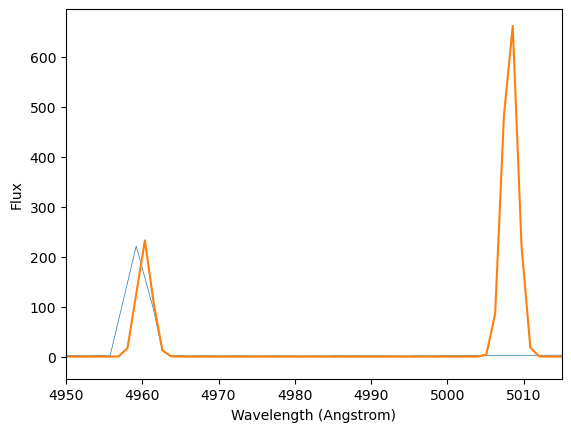

In [11]:
parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux,sigma = uncert,  method = "lm", p0=[60, 2])
print(parameters)
fit_A, fit_B= parameters
fit_y = Gauss(wavelength/(1+z), fit_A, fit_B)

#Plots the gaussian
plt.plot(wavelength/(1+z), flux, linewidth=0.5, label='Data')
plt.plot(wavelength/(1+z), fit_y, '-', label='Fit')

#ranges of x to show
plt.xlim(4950, 5015)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")

plt.show()

### Gauss of narrow + broad (with length units)

In [51]:
def h_alpha(x, amp, wid):
    return (amp * np.exp(-(x - 6564.61)**2 / (2 * wid**2)))
    
def n_ii_1(x, amp, wid):
    return (amp * np.exp(-(x - 6549.86)**2 / (2 * wid**2)))

def n_ii_2(x, amp, wid):
    return (3*amp * np.exp(-(x - 6585.27)**2 / (2 * wid**2)))

def broad(x, amp, wid):
    return (amp * np.exp(-(x - 6564.61)**2 / (2 * (wid)**2)))

def Gauss(x,amp1, amp2, amp3, wid1, wid2):
    return h_alpha(x, amp1, wid1) + n_ii_1(x, amp2, wid1) + n_ii_2(x, amp2, wid1) + broad(x, amp3, wid2)

In [47]:
#Fitting the spectrum to a continuum using fit_generic_spectrum from Specutils
uerg = u.erg/(u.s*u.cm**2*u.AA)
spec1d = Spectrum(spectral_axis=wavelength/(1+z)*u.AA, flux=flux*uerg)
continuum=fit_generic_continuum(spec1d)
print(continuum)
fit_cont = continuum(wavelength/(1+z)*u.AA)

<QuantityModel Chebyshev1D(3, c0=-4.2187464, c1=0.00416772, c2=-0.00000041, c3=0.), input_units=Angstrom, return_units=erg / (Angstrom s cm2)>


[303.57482711   0.38979352   3.7346124    1.27019292   5.23127006]


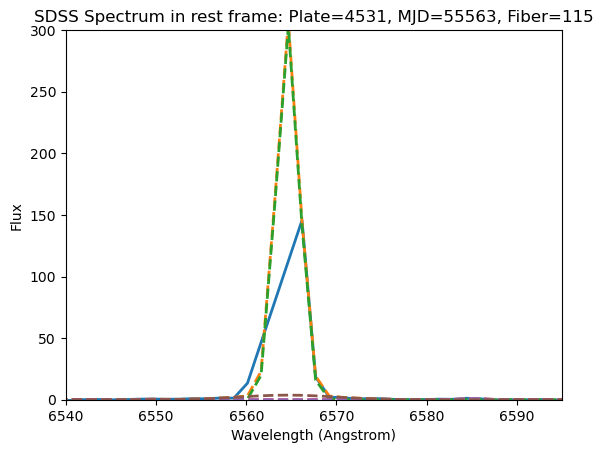

In [53]:
flux_normal = flux*uerg-fit_cont #normalized flux minus continuum

parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux_normal,sigma = uncert,  method = "lm", p0=[200, 8, 2, 2, 5])
print(parameters)
A, B, C, D, E= parameters
fit_y = Gauss(wavelength/(1+z), A, B, C, D, E)


#Plots the gaussian with the fits
plt.plot(wavelength/(1+z), flux_normal, linewidth=2, label='Data')
plt.plot(wavelength/(1+z), fit_y, '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), h_alpha(wavelength/(1+z), A, D), '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), n_ii_1(wavelength/(1+z), B, D), '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), n_ii_2(wavelength/(1+z), B, D), '--',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), broad(wavelength/(1+z), C, E), '--',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(6540, 6595)
plt.ylim(0,300)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#save the fit file
plt.savefig("Gaussian_fit_length.png")
plt.show()

### Testing out time units

In [55]:
#Test h-alpha fit first with length units still
def h_alpha(x, amp, wid):
    return (amp * np.exp(-(x - 6564.61)**2 / (2 * wid**2)))

[270.7650961    1.37103595]


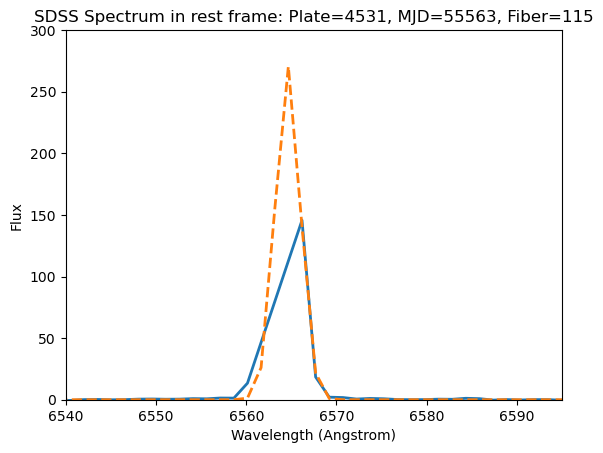

In [57]:
parameters, covariance = curve_fit(h_alpha, wavelength/(1+z), flux_normal,sigma = uncert,  method = "lm", p0=[200, 8])
print(parameters)
A, B = parameters

#Plots the gaussian with the fits
plt.plot(wavelength/(1+z), flux_normal, linewidth=2, label='Data')
plt.plot(wavelength/(1+z), h_alpha(wavelength/(1+z), A, B), '--',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(6540, 6595)
plt.ylim(0,300)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

plt.show()

In [59]:
#With velocity units
c = 3*10**5 #km/s
def h_alpha(x, amp, sig, v):
    x_0 = 6564.61 * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x - x_0)**2 / (2 * wid**2)))

[2.70758250e+02 6.26564335e+01 2.94712704e-12]


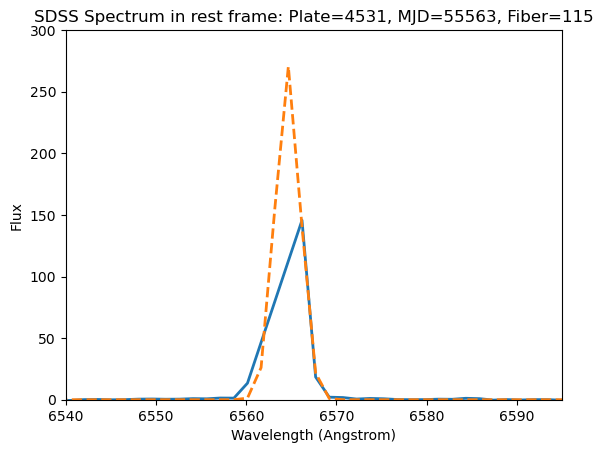

In [61]:
#set infinity to a constant for easy use
inf = math.inf
parameters, covariance = curve_fit(h_alpha, wavelength/(1+z), flux_normal,sigma = uncert,  method = "trf", p0=[150, 50, 50], bounds=([0,0,0],[inf, inf, inf]))
print(parameters)
A, B, C = parameters

#plots the gaussian with fits
plt.plot(wavelength/(1+z), flux_normal, linewidth=2, label='Data')
plt.plot(wavelength/(1+z), h_alpha(wavelength/(1+z), A, B, C), '--',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(6540, 6595)
plt.ylim(0,300)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

plt.show()

### Fitting all gaussians in time units

In [71]:
c = 3*10**5 #km/s
inf = math.inf

def h_alpha(x, amp, sig, v):
    x_0 = 6564.61*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * wid**2)))

def n_ii_1(x, amp, sig, v):
    x_0 = 6549.86*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * wid**2)))

def n_ii_2(x, amp, sig, v):
    x_0 = 6585.27*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (3*amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * wid**2)))

def broad(x, amp, sig, v):
    x_0 = 6564.61*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * (wid)**2)))

def Gauss(x,amp1, amp2, amp3, sig1, sig2, v_n, v_b):
    return h_alpha(x, amp1, sig1, v_n) + n_ii_1(x, amp2, sig1, v_n) + n_ii_2(x, amp2, sig1, v_n) + broad(x, amp3, sig2, v_b)

[2.88175463e+02 2.39202243e-01 1.30994368e+00 6.03439411e+01
 5.00000000e+02 1.82539437e-10 2.35949633e-08]


Text(0.5, 1.0, 'SDSS Spectrum in rest frame: Plate=4531, MJD=55563, Fiber=115')

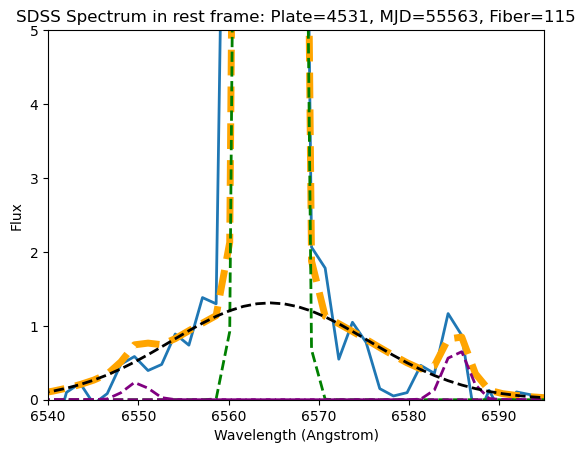

In [73]:
parameters, covariance = curve_fit(Gauss, wavelength/(1+z), flux_normal,sigma = uncert,  method = "trf", p0=[150,20,2, 50, 1000, 50, 50], bounds=([0,0,0,50,500, 0, 0],[inf, inf,5,500, 5000, inf, inf]))
print(parameters)
A, B, C, D, E, F, G = parameters
fit = Gauss(wavelength/(1+z), A, B, C, D, E, F, G)

#plots the gaussian with fits
fig, ax = plt.subplots()
plt.plot(wavelength/(1+z), flux_normal, linewidth=2, label='Data')
plt.plot(wavelength/(1+z), fit, '--', color = 'orange',linewidth=5, label='Fit')
plt.plot(wavelength/(1+z), h_alpha(wavelength/(1+z), A, D, F), '--',color = 'green',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), n_ii_1(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), n_ii_2(wavelength/(1+z), B, D, F), '--',color = 'purple',linewidth=2, label='Fit')
plt.plot(wavelength/(1+z), broad(wavelength/(1+z), C, E, G), '--',color = 'black',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(6540, 6595)
plt.ylim(0,5)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

(6540.0, 6595.0)

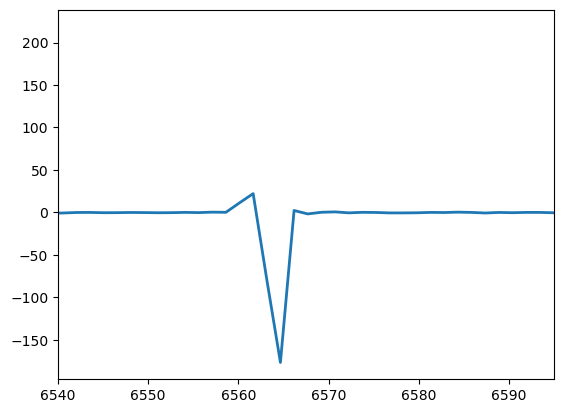

In [77]:
#Residuals (this one has a clipped one)
plt.plot(wavelength/(1+z), flux_normal-Gauss(wavelength/(1+z), A, B, C, D, E, F, G)*uerg, linewidth=2, label='Data')
plt.xlim(6540, 6595)